# Importing Libraries

In [24]:
import glob
import os

import imageio
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
from numpy.random import randint
import PIL
import tensorflow as tf
import cv2

# Loading Files

In [2]:
images = np.load('/home/sebastien/Bureau/Breast_Cancer_Gan/X.npy')
labels = np.load('/home/sebastien/Bureau/Breast_Cancer_Gan/Y.npy')

print(f'shape of images : {images.shape}')
print(f'shape of labels : {labels.shape}')

shape of images : (5547, 50, 50, 3)
shape of labels : (5547,)


# Ploting some examples

(-0.5, 49.5, 49.5, -0.5)

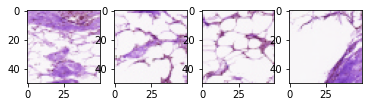

In [3]:
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
plt.axis("on")

plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))
plt.axis("on")

plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(images[3], cv2.COLOR_BGR2RGB))
plt.axis("on")

plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(images[4], cv2.COLOR_BGR2RGB))
plt.axis("on")


In [4]:
print(f'Size of images single image : {images[0].shape}')
print(f'Type of images single image : {images[0].max()}')

Size of images single image : (50, 50, 3)
Type of images single image : 252


In [5]:
def preprocess_images(images_dataset):

    images_dataset = (images_dataset - 127.5) / 127.5
    return images_dataset

X = preprocess_images(images)

# Defining Model

## Discriminator

In [6]:
def build_discriminator(input_shape = (50,50,3)):

    discriminator = tf.keras.Sequential([

        tf.keras.layers.Conv2D(64, (3,3), padding = 'same', input_shape = input_shape, activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Input_layer'),
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same', strides = (2,2), activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Downsampling_1'),
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same', strides = (2,2), activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Downsampling_2'),
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same', strides = (2,2), activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Downsampling_3'),
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same', strides = (2,2), activation = tf.keras.layers.LeakyReLU(alpha = 0.2), name = 'Downsampling_4'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
            ])

    opt = tf.keras.optimizers.Adam(lr= 0.0002, beta_1 = 0.5)
    discriminator.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])


    return discriminator

In [7]:
discriminator_test = build_discriminator()
discriminator_test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Conv2D)         (None, 50, 50, 64)        1792      
_________________________________________________________________
Downsampling_1 (Conv2D)      (None, 25, 25, 128)       73856     
_________________________________________________________________
Downsampling_2 (Conv2D)      (None, 13, 13, 128)       147584    
_________________________________________________________________
Downsampling_3 (Conv2D)      (None, 7, 7, 128)         147584    
_________________________________________________________________
Downsampling_4 (Conv2D)      (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0

## Generator

In [8]:
def build_generator(lattent_dimension = 100):

    """
    Padding : if "same" Wout = Win * stride, if "valid" Wout = (Win-1) + Stride * Ksize

    """

    n_nodes = 256 * 5 * 5

    generator = tf.keras.Sequential([

        tf.keras.layers.Dense(n_nodes, input_dim = lattent_dimension, activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Dense_in'),
        tf.keras.layers.Reshape((5, 5, 256), name = 'Reshaping'),
        tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same',  activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Upsampling_1'), # upsampling to :10 x 10
        tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same',  activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Upsampling_2'), # upsampling to :20 x 20
        tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same',  activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Upsampling_3'), # upsampling to :40 x 40
        tf.keras.layers.Conv2DTranspose(128, (11,11), strides = (1,1), padding = 'valid',  activation = tf.keras.layers.LeakyReLU(alpha=0.02), name = 'Upsampling_4'), # upsampling to :50 x 50
        tf.keras.layers.Conv2D(3, (3,3), activation = 'tanh', padding = 'same', name = 'Discriminator_fitting') # Formating the ouutput of generator to match discriminator input
    ])

    return generator

In [9]:
test_generator = build_generator()

In [10]:
test_generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_in (Dense)             (None, 6400)              646400    
_________________________________________________________________
Reshaping (Reshape)          (None, 5, 5, 256)         0         
_________________________________________________________________
Upsampling_1 (Conv2DTranspos (None, 10, 10, 128)       524416    
_________________________________________________________________
Upsampling_2 (Conv2DTranspos (None, 20, 20, 128)       262272    
_________________________________________________________________
Upsampling_3 (Conv2DTranspos (None, 40, 40, 128)       262272    
_________________________________________________________________
Upsampling_4 (Conv2DTranspos (None, 50, 50, 128)       1982592   
_________________________________________________________________
Discriminator_fitting (Conv2 (None, 50, 50, 3)        

## Gan Model

In [17]:
def build_gan(generator_model, discriminator_model):

    discriminator_model.trainable = False

    model = tf.keras.Sequential([

        generator_model,
        discriminator_model
    ])

    opt = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = opt)

    return model

In [19]:
test_gan = build_gan(test_generator, discriminator_test)
test_gan.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 50, 50, 3)         3681411   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 520449    
Total params: 4,201,860
Trainable params: 3,681,411
Non-trainable params: 520,449
_________________________________________________________________


In [12]:
def generate_real_samples(dataset, n_samples):

    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples,1))

    return X, y 

In [13]:
def generate_latent_points(latent_dim, n_samples):

	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [26]:
def generate_fake_samples(generator_model, lattent_dimension, n_samples):

    x_input = generate_latent_points(lattent_dimension, n_samples) # generate points in the latent space
    X = generator_model.predict(x_input) # prediction from generated points
    y = np.zeros((n_samples, 1)) # creating fake class (0)

    return X, y

In [15]:
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [20]:
def summarize_performance(epoch, generator_model, discriminator_model, dataset, lattent_dimension, n_samples = 150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator_model, lattent_dimension, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = discrininator_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	generator_model.save(filename)

### Defining training

In [28]:
def train_gan(generator_model, discriminator_model, gan_model, dataset, lattent_dimension, n_epochs = 200, n_batch = 128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = discriminator_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(generator_model, lattent_dimension, half_batch)
			# update discriminator model weights
			d_loss2, _ = discriminator_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(lattent_dimension, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, generator_model, discriminator_model, dataset, lattent_dimension)

## Performing Experience

In [29]:
lattent_dimension = 100

discriminator_model = build_discriminator()

generator_model = build_generator(lattent_dimension)

gan_model = build_gan(generator_model, discriminator_model)

dataset = preprocess_images(images)



/home/sebastien/miniconda3/envs/Projets/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [30]:
train_gan(generator_model, discriminator_model, gan_model, dataset, lattent_dimension)

>1, 1/43, d1=0.690, d2=0.695 g=0.692
>1, 2/43, d1=0.616, d2=0.703 g=0.684
>1, 3/43, d1=0.536, d2=0.736 g=0.654
>1, 4/43, d1=0.443, d2=0.850 g=0.592
>1, 5/43, d1=0.360, d2=1.036 g=0.552
>1, 6/43, d1=0.384, d2=1.053 g=0.610
>1, 7/43, d1=0.439, d2=0.909 g=0.721
>1, 8/43, d1=0.540, d2=0.773 g=0.789
>1, 9/43, d1=0.618, d2=0.850 g=0.765
>1, 10/43, d1=0.664, d2=0.866 g=0.838
>1, 11/43, d1=0.690, d2=0.612 g=1.093
>1, 12/43, d1=0.738, d2=0.412 g=1.505
>1, 13/43, d1=0.737, d2=0.260 g=2.029
>1, 14/43, d1=0.698, d2=0.148 g=2.771
>1, 15/43, d1=0.650, d2=0.075 g=3.244
>1, 16/43, d1=0.516, d2=0.045 g=3.671
>1, 17/43, d1=0.429, d2=0.045 g=3.884
>1, 18/43, d1=0.308, d2=0.027 g=4.189
>1, 19/43, d1=0.192, d2=0.020 g=4.564
>1, 20/43, d1=0.120, d2=0.014 g=4.805
>1, 21/43, d1=0.073, d2=0.010 g=5.123
>1, 22/43, d1=0.058, d2=0.009 g=5.333
>1, 23/43, d1=0.080, d2=0.008 g=5.475
>1, 24/43, d1=0.067, d2=0.009 g=5.575
>1, 25/43, d1=0.028, d2=0.004 g=5.883
>1, 26/43, d1=0.032, d2=0.004 g=5.914
>1, 27/43, d1=0.035, 

NameError: name 'discrininator_model' is not defined